   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region       Product ID

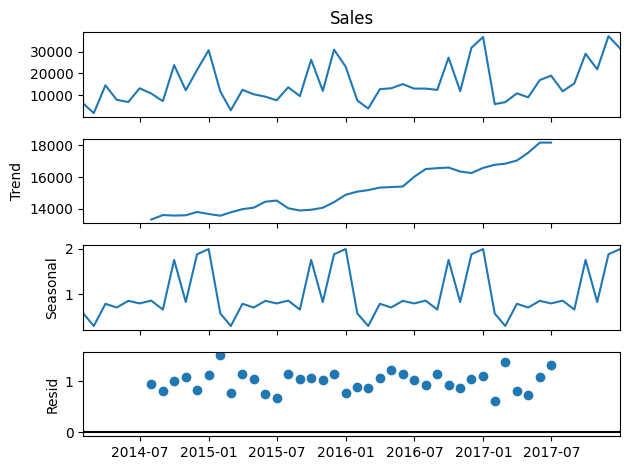

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset with specified encoding
sales_data = pd.read_csv('stores_sales_forecasting.csv', encoding='latin1')

# Display the first few rows of the dataset
print(sales_data.head())

# Convert the 'Order Date' column to datetime
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

# Set the 'Order Date' column as the index
sales_data.set_index('Order Date', inplace=True)

# Check for missing values
print(sales_data.isnull().sum())

# Handle missing values (if any)
sales_data.fillna(0, inplace=True)

# Resample the data to monthly frequency and sum the sales
monthly_sales = sales_data['Sales'].resample('M').sum()

# Display the first few rows of the resampled data
print(monthly_sales.head())

# Decompose the time series
result = seasonal_decompose(monthly_sales, model='multiplicative')

# Plot the decomposed components
result.plot()
plt.show()


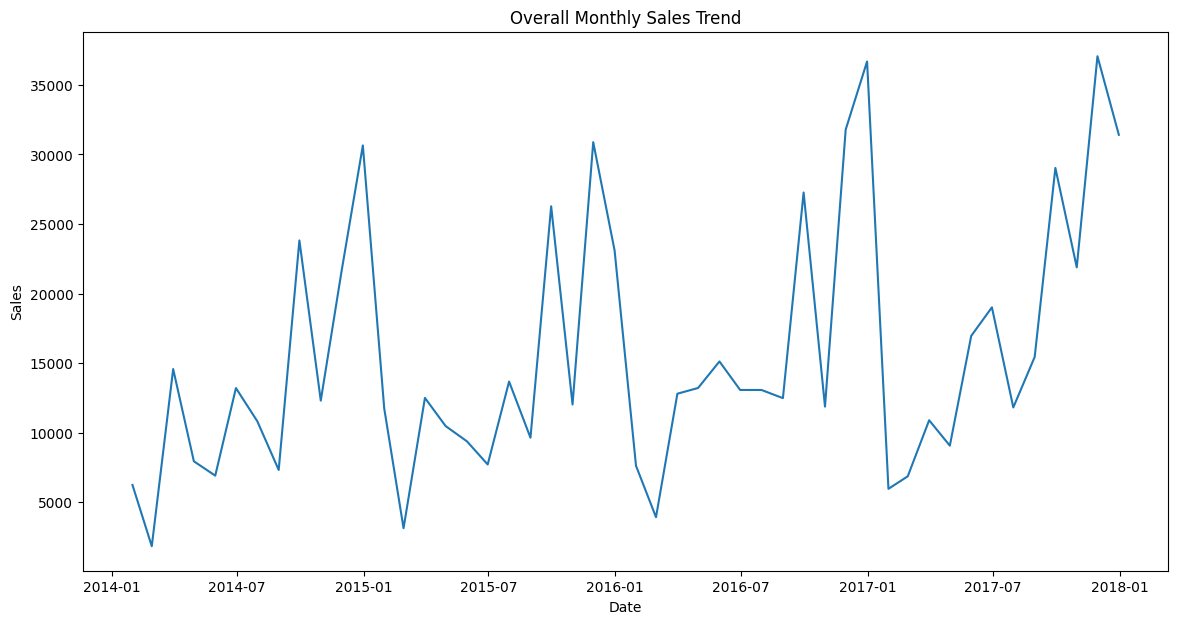

In [22]:
import seaborn as sns

# Plot the overall sales trend
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales)
plt.title('Overall Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


In [ ]:
# for arima

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -494.372
Date:                Mon, 17 Jun 2024   AIC                            994.745
Time:                        09:22:07   BIC                           1000.295
Sample:                    01-31-2014   HQIC                           996.833
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2602      0.283      0.919      0.358      -0.295       0.815
ma.L1         -0.8855      0.162     -5.475      0.000      -1.202      -0.568
sigma2      9.203e+07   1.07e-09   8.61e+16      0.0

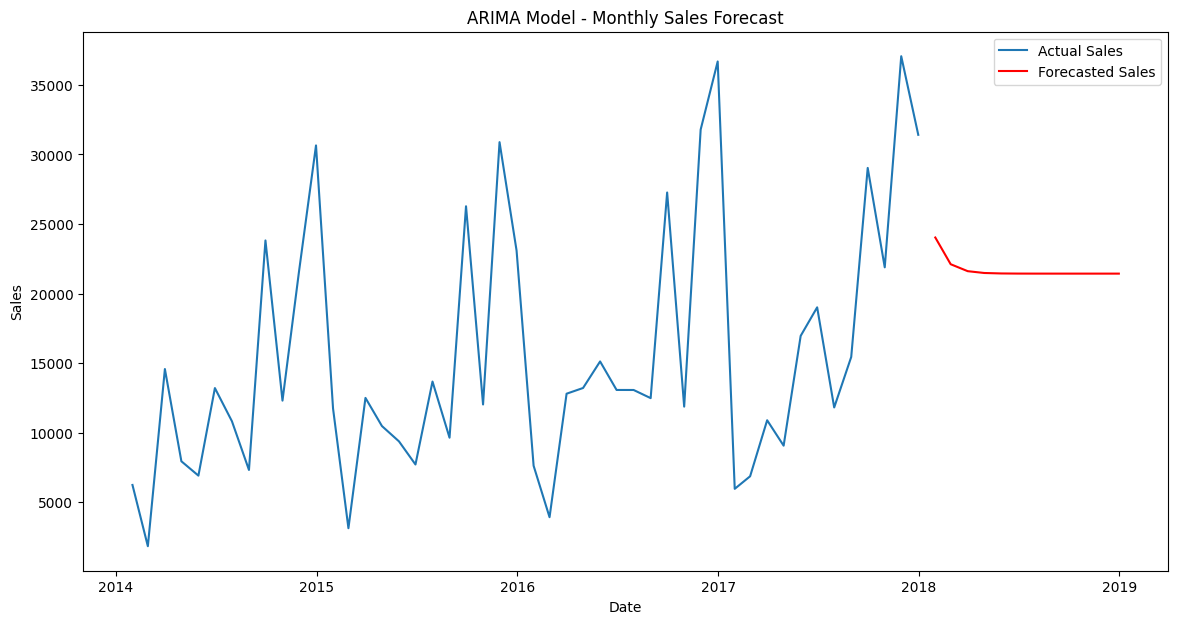

In [23]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
model = ARIMA(monthly_sales, order=(1, 1, 1))
arima_result = model.fit()

# Print the model summary
print(arima_result.summary())

# Forecast for the next 12 months
forecast_arima = arima_result.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, label='Actual Sales')
plt.plot(forecast_arima, label='Forecasted Sales', color='red')
plt.title('ARIMA Model - Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [24]:
# for prophet

In [28]:
!pip install prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfmwmu_5/vwlq62n2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfmwmu_5/ghidpk2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40135', 'data', 'file=/tmp/tmpjfmwmu_5/vwlq62n2.json', 'init=/tmp/tmpjfmwmu_5/ghidpk2w.json', 'output', 'file=/tmp/tmpjfmwmu_5/prophet_modelx39b0eag/prophet_model-20240617092421.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


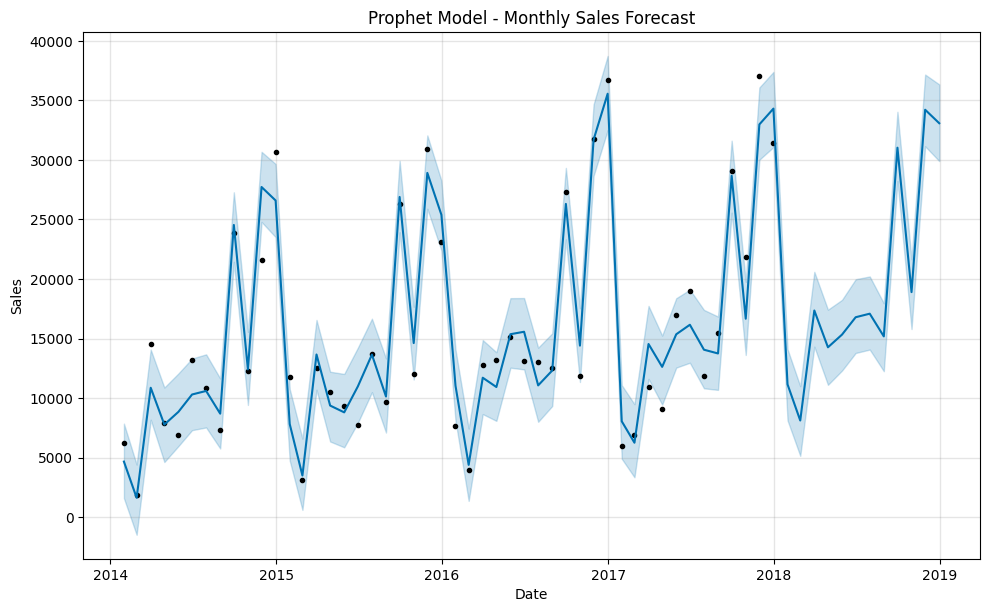

In [29]:
from prophet import Prophet

# Prepare the data
prophet_data = monthly_sales.reset_index()
prophet_data.columns = ['ds', 'y']

# Define the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=12, freq='M')

# Forecast
forecast_prophet = prophet_model.predict(future)

# Plot the forecast
fig = prophet_model.plot(forecast_prophet)
plt.title('Prophet Model - Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate ARIMA model
y_true = monthly_sales[-12:]  # Last 12 months of actual sales
y_pred_arima = forecast_arima[:12]
mae_arima = mean_absolute_error(y_true, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

print(f'ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}%')

# Evaluate Prophet model
y_pred_prophet = forecast_prophet['yhat'][-12:].values
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred_prophet)

print(f'Prophet Model - MAE: {mae_prophet}, RMSE: {rmse_prophet}, MAPE: {mape_prophet}%')


ARIMA Model - MAE: 9383.444891481462, RMSE: 10737.006127938454, MAPE: nan%
Prophet Model - MAE: 3081.2723708823687, RMSE: 3610.5406604315867, MAPE: 26.911327090671826%
